In [129]:
# -- IMPORTATION OF THE PACKAGES --
import DataFrames 
import XLSX
import Plots
include("structs.jl")
include("read_network_data.jl")

get_network_data

In [4]:
# -- FETCHING THE PATH OF THE ROOT DIRECTORY --

root_dir = normpath(joinpath(@__FILE__,"..","..",".."))

"/Users/manoncornet/Documents/University/TFE/Bilevel_DNEP/"

In [5]:
# -- LOADING THE EXCEL FILE CONTAINING THE NETWORK TOPOLOGY --

network_data_dir = joinpath(root_dir, "NetworkModels")
XLSX_NETWORK_PATH = joinpath(network_data_dir, "network_Nahman_Peric_2S23H.xlsx")

"/Users/manoncornet/Documents/University/TFE/Bilevel_DNEP/NetworkModels/network_Nahman_Peric_2S23H.xlsx"

In [76]:
# -- LOADING THE EXCEL FILES CONTAINING THE DATA FOR LOAD AND PV PROFILES --

profiles_data_dir = joinpath(root_dir, "ManchesterData", "LCT_profiles")
XLSX_SUMMER_LOAD_PATH = joinpath(profiles_data_dir, "Summer_Load_Profiles.xlsx")
XLSX_WINTER_LOAD_PATH = joinpath(profiles_data_dir, "Winter_Load_Profiles.xlsx")
XLSX_PV_PATH = joinpath(profiles_data_dir, "Summer_PV_Profiles.xlsx")
XLSX_EV_PATH = joinpath(profiles_data_dir, "Winter_EV_Profiles.xlsx")
XLSX_HP_PATH = joinpath(profiles_data_dir, "Winter_EHP_Profiles.xlsx")

"/Users/manoncornet/Documents/University/TFE/Bilevel_DNEP/ManchesterData/LCT_profiles/Winter_EHP_Profiles.xlsx"

In [100]:
# PROFILES is a list that contains the path to the significative days profiles 

function create_base_load_profiles( PROFILES::Vector{String},
                                    nb_profiles::Int64; 
                                    peak_power::Union{Nothing, Float64} = nothing,
                                    # peak_distribution::Union{Nothing, Vector{Float64}} = nothing,
                                    seed::Union{Nothing, Int64} = nothing
                                )

    # Checking if peak_distribution is well a distribution
    #if !isnothing(peak_distribution)                            
    #    @assert sum(peak_distribution) == 1
    #end

    nrows, ncols = size(XLSX.readxlsx(PROFILES[1])[1][:])
    # Fixing the seed to choose randomly the load profiles selected 
    if !isnothing(seed)
        Random.seed!(seed)
        id_loads = Random.rand(1:ncols, nb_profiles)
    else 
        id_loads = 1:nb_profiles
    end

    base_load_profiles = Matrix{Float64}(undef, 0, nb_profiles)

    for file in PROFILES 
        profiles = convert(Matrix{Float64}, XLSX.readxlsx(file)[1][:])
        selected_profiles = reshape(profiles[:, id_loads], (nrows, nb_profiles))
        base_load_profiles = vcat(base_load_profiles, selected_profiles)
    end
    

    if !isnothing(peak_power)
        initial_peak_value, index_peak = findmax(vec(sum(base_load_profiles, dims=2)))
        #if !isnothing(peak_distribution)
        #    base_load_profiles = base_load_profiles ./ base_load_profiles[index_peak, :]' .* peak_distribution' .* peak_power
            #println(base_load_profiles ./ base_load_profiles[index_peak, :]')
        #else
        base_load_profiles *= peak_power / initial_peak_value
        #end
    end

    
    return base_load_profiles
end

create_base_load_profiles (generic function with 1 method)

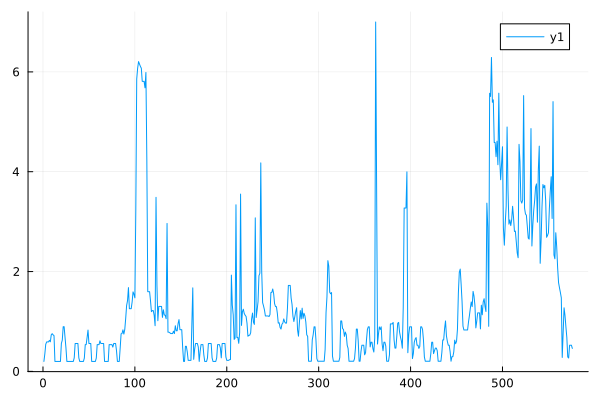

In [111]:
# -- Test function --
# Profiles of the significative days
PROFILES = [XLSX_SUMMER_LOAD_PATH, XLSX_WINTER_LOAD_PATH]
base_load_profiles = create_base_load_profiles(PROFILES, 2; 
                              peak_power=7.0,
                                )



In [ ]:
function create_simulation_profiles( PROFILES::Vector{String},
    nb_profiles::Int64; 
    peak_power::Union{Nothing, Float64} = nothing,
    # peak_distribution::Union{Nothing, Vector{Float64}} = nothing,
    seed::Union{Nothing, Int64} = nothing
)

In [44]:
base_load_profiles = [ 1 1 1 4; 2 3 4 3; 2 4 5 7; 2 2 2 8]
peak_distribution = 1/4*ones(4)
peak_power = 7
if !isnothing(peak_power)
    initial_peak_value, index_peak = findmax(vec(sum(base_load_profiles, dims=2)))
    if !isnothing(peak_distribution)
        base_load_profiles = base_load_profiles ./ base_load_profiles[index_peak, :]' .* peak_distribution' * peak_power
    else
        base_load_profiles *= peak_power / initial_peak_value
    end
    println(size(base_load_profiles))
    println(maximum(sum(base_load_profiles, dims=2)))
end

(4, 4)
7.0


In [5]:
# -- Verification of the above code --
network_data, network_typology = get_network_data(XLSX_NETWORK_PATH)

(DistributionNetwork(Line[Line(Edge(1, Node(1, (x = 8.525, y = 6.055)), Node(10, (x = 8.325, y = 6.026))), 0.20209156340629467, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(2, Node(10, (x = 8.325, y = 6.026)), Node(20, (x = 8.825, y = 6.512))), 0.697277563098082, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(3, Node(10, (x = 8.325, y = 6.026)), Node(14, (x = 7.925, y = 5.869))), 0.42970804041814203, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(4, Node(10, (x = 8.325, y = 6.026)), Node(19, (x = 8.868, y = 5.783))), 0.5948932677380043, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(5, Node(19, (x = 8.868, y = 5.783)), Node(20, (x = 8.825, y = 6.512))), 0.7302670744323606, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(6, Node(19, (x = 8.868, y = 5.783)), Node(21, (x = 9.039, y = 5.255))), 0.5550000000000003, false, nothing, nothing, nothing, nothing, nothing), Line(Edge(7, Node(19, (x = 8.868, y = 5.783)

In [ ]:
# -- Function that prints the initial network structure -- 

function Base.show(io::IO, data::User) 
    println(io, "User bus : ")
    println(io, "--------- ")
    println(io, " - At node $(data.node.id)")
    println(io, " - V in [$(data.V_limits.V_min), $(data.V_limits.V_max)]")
    if !isnothing(data.load_profile)
        println(io, " - Total S consumption = $(sum(data.load_profile.profile .* data.load_profile.granularity))")
        println(io, " - cos(phi) = $(data.load_profile.cos_phi)")
    end
    if !isnothing(data.V_magn)
        println(io, " - V = $(data.V_magn) [pu]")
    end
    if !isnothing(data.PV_installation)
        println(io, " - PV installation : yes")
    else
        println(io, " - PV installation : no")
    end
  
    return 
end


In [ ]:
# -- DEFINITIONS OF THE PARAMETERS FOR LOAD PROFILES --

WINTER = true               # extend the summer profile
ELECTRIC_VEHICLES = false   # added to summer & winter profiles
HEAT_PUMPS = false          # added to winter profile only
PEAK_POWER = 7              # [MVA] maximum power of all the apparent demands
DELTA_T = 15                # [min] Duration of a time step in time series

In [ ]:
# -- DEFINITIONS OF THE PARAMETERS REQUIRED FOR PV --
MAX_PV_CAPACITY_PER_NODE = 0.4 # MVA 
PV_SCALE_SUMMER_WINTER = 0.1 # winter PV production wrt summer production
PV_MAX_Q = 0.3 # max Q consumed/produced wrt P_peak
PV_SLOPE = -1 # linear slope of the upper bound from the PQ diagram of PV
COS_PHI = 0.95 # P_CONSUMPTION = COS_PHI * S_CONSUMPTION


In [ ]:
for i in network_data.load_buses
    show(i)
end


In [140]:
include("profiles.jl")

plot_profiles (generic function with 1 method)

In [115]:
# -- LOADING THE EXCEL FILES CONTAINING THE DATA FOR LOAD AND PV PROFILES --

profiles_data_dir = joinpath(root_dir, "ManchesterData", "LCT_profiles")
SUMMER_LOAD_PATH = joinpath(profiles_data_dir, "Summer_Load_Profiles.xlsx")
WINTER_LOAD_PATH = joinpath(profiles_data_dir, "Winter_Load_Profiles.xlsx")
PV_PATH = joinpath(profiles_data_dir, "Summer_PV_Profiles.xlsx")
EV_PATH = joinpath(profiles_data_dir, "Winter_EV_Profiles.xlsx")
HP_PATH = joinpath(profiles_data_dir, "Winter_EHP_Profiles.xlsx")

"/Users/manoncornet/Documents/University/TFE/Bilevel_DNEP/ManchesterData/LCT_profiles/Winter_EHP_Profiles.xlsx"

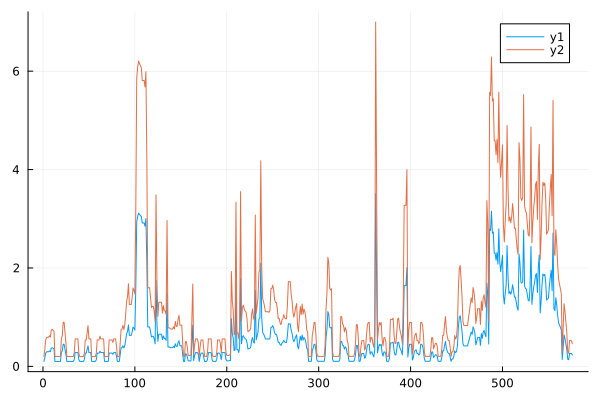

In [142]:
# -- CREATING THE LOAD PROFILES --

# Definition of time constants
HOURS_PER_YEAR = 8760
DAYS_A_YEAR = 365
GRANULARITY = 5 # [min.] (granularity of the dataset that you use)

# Definition of the time_step of simulation
NB_SIMULATED_DAYS = 2
DELTA_T= 15         # size of a time step (must be in minutes)

nb_agg_time_steps = process_time_steps(delta_t=DELTA_T, data_granularity=GRANULARITY)

PROFILE_PATHS = [SUMMER_LOAD_PATH, WINTER_LOAD_PATH]

daily_profiles =[   build_daily_load_profiles(path, 2) 
                        for path in PROFILE_PATHS]

load_profiles, peak_value, peak_time_step = build_load_profiles(daily_profiles)

Plots.plot(1:size(load_profiles)[1], sum(load_profiles, dims=2))

scaling_factor = 7 / peak_value

load_profiles, peak_value, peak_time_step = build_load_profiles(daily_profiles, scaling_factor=scaling_factor)

Plots.plot!(1:size(load_profiles)[1], sum(load_profiles, dims=2))


In [ ]:
# -- Plot profiles --